In [1]:
import torch 
import numpy as np
import os 
import sys
import os.path as osp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

In [2]:
!ls data

2016_2018         tensor_completion y.npy
data_era          vision_data.npy


# 1- Load the data using the loader. Depending on the mode chosen, the iterator will output different dictionaries.

In [3]:
from dataclasses import dataclass, field, asdict
import imp

@dataclass
class Args:
    data_dir: str
    y_name: str
    vision_name: str
    predict_at: int
    window_size: int
    train_test_split: float
    mode: str
    batch_size: int
        
args = Args(data_dir="data/", 
            y_name="y.npy",
           vision_name="vision_data.npy", 
           predict_at=8,
           window_size=8, 
           train_test_split=0.8, 
           batch_size=10, 
           mode='intensity')

from src.prepro import create_loaders
train_loader, test_loader = create_loaders(**vars(args), debug=False)

New dataset and corresponding sizes (null elements included):
X_vision torch.Size([3735, 8, 9, 25, 25])
X_stat torch.Size([3735, 8, 10])
target_displacement torch.Size([3735, 8, 2])
target_intensity torch.Size([3735])
target_intensity_cat torch.Size([3735])
target_intensity_cat_baseline torch.Size([3735])
Keeping 3143 samples out of the initial 3735.
Reshaping the displacement target...


**How does create_loaders work ?**
```python

vision_data = np.load(osp.join(data_dir, vision_name),
                          allow_pickle=True)
y = np.load(osp.join(data_dir, y_name),
                allow_pickle=True)

#Create named tensors
train_tensors, test_tensors = Prepro.process(
        y=y, 
        vision_data=vision_data,
        train_split=train_test_split,
        predict_at=predict_at,
        window_size=window_size)

#Filter the relevant keys
train_tensors, test_tensors = filter_keys(
     train_tensors, test_tensors, mode=mode)

#Unroll in tensordataset
train_ds = TensorDataset(*train_tensors.values())
test_ds = TensorDataset(*test_tensors.values())
    
#Create collate_fn 
collate_fn = create_collate_fn()


train_loader = DataLoader(train_ds, 
                            batch_size=batch_size, 
                            shuffle=True, 
                            drop_last=True,
                            collate_fn=collate_fn)

test_loader = DataLoader(test_ds, 
                            batch_size=batch_size, 
                            shuffle=False, 
                            collate_fn=collate_fn)
```

In [4]:
in_model, in_loss = next(iter(train_loader))
for k, v in in_model.items(): print('in_model', k, v.size())
for k, v in in_loss.items(): print('in_loss', k, v.size())

in_model x_viz torch.Size([10, 8, 9, 25, 25])
in_model x_stat torch.Size([10, 8, 10])
in_loss trg_y torch.Size([10])


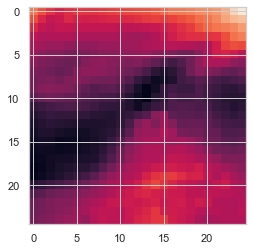

In [5]:
plt.imshow(in_model['x_viz'][0,0,1].detach().numpy());plt.show()

# 2 - Models
Experimental version in experimental_models (TO COME, see below).
___
The different configurations are stored in scripts/config.py.
We create a model as follows:

In [6]:
"""
#import imp
#import src
#imp.reload(src.models)
#imp.reload(src.models.factory)
#imp.reload(src.models.hurricast_models)
#import src.models
#del args.device
#del args.writer
from dataclasses import dataclass, field, asdict
import imp

@dataclass
class Args:
    data_dir: str
    y_name: str
    vision_name: str
    predict_at: int
    window_size: int
    train_test_split: float
    mode: str
    batch_size: int
        
args = Args(data_dir="data/", 
            y_name="y.npy",
           vision_name="vision_data.npy", 
           predict_at=8,
           window_size=8, 
           train_test_split=0.8, 
           batch_size=10, 
           mode='intensity')
"""

'\n#import imp\n#import src\n#imp.reload(src.models)\n#imp.reload(src.models.factory)\n#imp.reload(src.models.hurricast_models)\n#import src.models\n#del args.device\n#del args.writer\nfrom dataclasses import dataclass, field, asdict\nimport imp\n\n@dataclass\nclass Args:\n    data_dir: str\n    y_name: str\n    vision_name: str\n    predict_at: int\n    window_size: int\n    train_test_split: float\n    mode: str\n    batch_size: int\n        \nargs = Args(data_dir="data/", \n            y_name="y.npy",\n           vision_name="vision_data.npy", \n           predict_at=8,\n           window_size=8, \n           train_test_split=0.8, \n           batch_size=10, \n           mode=\'intensity\')\n'

In [7]:
#if args.encdec: decoder_config = config.encdec_config
#elif args.transformer: decoder_config=config.transformer_config
#else: decoder_config = config.lineartransform_config
import sys
sys.path.append("../")
from scripts import config
from src.models import factory, hurricast_models
from src import setup
#Just a hack for the notebook
args.encdec = True
args.transformer = False
args.output_dir = 'results/companion_notebook'
writer = setup.create_board(args)
device = setup.create_device(gpu_nb=-1)
args.device = None
args.writer = writer
# End of the hack

 Prepare the training using  cpu


In [8]:
encoder_config = config.encoder_config
decoder_config = config.encdec_config

model = factory.get_model(
        mode=args.mode, 
        encoder_config=encoder_config,
        decoder_config=decoder_config, 
        args=args)

model

ENCDEC(
  (encoder): CNNEncoder(
    (activation): ReLU()
    (layers): Sequential(
      (0): Conv2d(9, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1))
      (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU()
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): Flatten()
      (12): Linear(in_features=4096, out_features=256, bias=True)
      (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (14): ReLU()
      (15): Linear(in_features=2

**What are the refistered models?**

In [9]:
print(factory.MODEL_REGISTRY)

{'CNNEncoder': <class 'src.models.hurricast_models.CNNEncoder'>, 'ENCDEC': <class 'src.models.hurricast_models.ENCDEC'>, 'TRANSFORMER': <class 'src.models.hurricast_models.TRANSFORMER'>, 'LINEARTransform': <class 'src.models.hurricast_models.LINEARTransform'>}


**The model creation is wrapped using the models/factory.py file and the function:**
```py
def get_model(mode, encoder_config, decoder_config, args):
    #Needs to upload window size and _OUT_DECODER
    #Get some
    assert (int(args.encdec) + int(args.transformer) < 2), "\
    Only one of encdec or transformer can be specified"

    _encoder = MODEL_REGISTRY['CNNEncoder']
    if args.encdec:
        _model = MODEL_REGISTRY['ENCDEC']
    elif args.transformer:
        _model = MODEL_REGISTRY['TRANSFORMER']
    else:
        model = MODEL_REGISTRY['LINEARTransform']

    N_OUT_DECODER = 7 if mode == 'intensity_cat' else (
        2 - (mode == 'intensity'))  # 7 classes of storms if categorical

    #Encoder
    encoder_config = encoder_config if isinstance(encoder_config, dict)\
        else vars(encoder_config)

    encoder = _encoder(**encoder_config)

    #Decoder: Update the config
    decoder_config = decoder_config if isinstance(decoder_config, dict)\
        else vars(encoder_config)

    if not args.encdec and not args.transformer:
        decoder_config['target_intensity'] = args.target_intensity,
        decoder_config['target_intensity_cat'] = args.target_intensity_cat

    else:
        decoder_config['encoder'] = encoder
        decoder_config['window_size'] = args.window_size
        decoder_config['n_out_decoder'] = N_OUT_DECODER

    model = _model(**decoder_config)

    model = model.to(args.device)

    if args.writer is not None:
        configs = [encoder_config, decoder_config]
        config_ = ""
        for config__ in configs:
            config_ += "{}\n".format(config__)
        args.writer.add_text('Configs', config_)
    return model
```


# 3  - Prepare the training

In [10]:
optimizer = torch.optim.Adam(
        model.parameters(),
        lr=1e-4)

In [11]:
#Hack for the notebook
from src import metrics, run
args.n_epochs = 1
args.get_training_stats = True
task = 'regression'
train_loss_fn, \
eval_loss_fn, metrics_fn = metrics.create_metrics_fn(task)

best_model, \
        optimizer, \
        training_stats = run.train(
            model, optimizer,
            num_epochs=args.n_epochs,
            train_loss_fn=train_loss_fn,
            test_loss_fn=eval_loss_fn,
            metrics_fn=metrics_fn,
            train_iterator=train_loader,
            val_iterator=test_loader,
            test_iterator=test_loader,
            mode=args.mode,
            task=task,
            get_training_stats=args.get_training_stats,
            clip=None,
            scheduler=None,
            l2_reg=0.,
            save=False,
            args=args,
            output_dir=args.output_dir,
            writer=args.writer)

Inner Training loop:   0%|          | 0/251 [00:00<?, ?it/s]/Users/theoguenais/anaconda/envs/graphcnn/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)

Inner Training loop:  42%|████▏     | 105/251 [01:20<01:44,  1.39it/s]


Inner Training loop:  86%|████████▌ | 215/251 [02:40<00:25,  1.41it/s]


Inner Training loop: 100%|██████████| 251/251 [03:06<00:00,  1.35it/s]
/Users/theoguenais/anaconda/envs/graphcnn/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([629])) that is different to the input size (torch.Size([629, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 0 | Loss 0.9798471331596375: 100%|██████████| 1/1 [03:14<00:00, 194.24s/it]


Could not write confusion_matrix due to name 'workspace' is not defined
Could not write accuracy due to name 'workspace' is not defined
Could not write precision due to name 'workspace' is not defined
Could not write recall due to name 'workspace' is not defined
Could not write f1 due to name 'workspace' is not defined
Could not write f1_micro due to name 'workspace' is not defined
Could not write f1_macro due to name 'workspace' is not defined
Could not write classification_report due to name 'workspace' is not defined
Epoch: 01 | Time: 3m 14s
	Train Loss: 1.0093 | Train PPL:   2.744
	 Val. Loss: 0.980 |  Val. PPL:   2.664
	 Final test ACC 0.980
Problem 'Args' object has no attribute 'lr'
Problem 'Args' object has no attribute 'l2_reg'
Problem 'Args' object has no attribute 'lr'
Problem 'Args' object has no attribute 'model'
Problem 'Args' object has no attribute 'num_epochs'


/Users/theoguenais/anaconda/envs/graphcnn/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([629])) that is different to the input size (torch.Size([629, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


### How does the training work exactly?
1. **We Backprop and train for one epoch**
```py
train_losses, \
preds, true_preds = train_epoch(
                        model=model,
                        train_iterator=train_iterator,
                        optimizer=optimizer,
                        loss_fn=train_loss_fn,
                        global_step=epoch,
                        task=get_training_stats,
                        return_pt=True,
                        l2_reg=l2_reg,
                        clip=clip,
                        scheduler=scheduler)
```
2. **Obtain the training metrics.**
```py
train_metrics = metrics_fn(preds, true_preds)
```   
3. **Eval (metrics obtained in the function directly).**
```py
preds, true_preds, \
valid_loss, eval_metrics = evaluate(
                                    model=model, 
                                    iterator=val_iterator,
                                    loss_fn=test_loss_fn,
                                    metrics_func=metrics_fn,
                                    task=task)
```

**We repeat the above for each epoch.**

The final output of the training is: 
```py
best_model, optimizer, training_stats : dict = {
                                'train_metrics': ...,
                                'eval_metrics': ...,
                                'test_metrics': ...,
                                'test_preds': ...,
                                'test_labels': ...
                                }
```                               